# Probabilistic Programming with Haskell

Siddhart Bath, Simeon Carstens, Matthias Meschede

_first published on www.tweag.io/blog_

#### imports

In [1]:
:e OverloadedStrings
:e ExistentialQuantification
:e FlexibleContexts

import System.Random.MWC (createSystemRandom)
import qualified Graphics.Vega.VegaLite as VL
import IHaskell.Display.Hvega (vlShow)
import Data.Aeson (ToJSON(toJSON), Value)
import Data.Aeson (encode)
import qualified Data.ByteString.Lazy.Char8 as BL
import Data.Text (Text, pack)
import qualified Data.Histogram as DH
import qualified Data.Histogram.Fill as DF
import qualified Data.Histogram.Bin.Bin2D as Bin2D
import Data.Vector.Unboxed.Base (Unbox)
import qualified Data.Vector.Unboxed as Vec

import Control.Monad (liftM2, replicateM, forM, forM_)
import Control.Monad.IO.Class (liftIO)
import Data.List (sort)
import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Sampler
import Control.Monad.Bayes.Traced
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Inference.SMC as SMC
import Control.Monad.Bayes.Inference.RMSMC as RMSMC
import Control.Monad.Bayes.Sequential
import Control.Monad.Bayes.Population
import Control.Monad.Bayes.Traced.Static (Traced)
import Control.Monad.Bayes.Inference.SMC
import Numeric.LinearAlgebra (Matrix, Vector, toList, vector, matrix, dot, (#>), (!), cmap, scalar, size)

import Numeric.Log
import Control.Monad.Bayes.Class

import Data.List (partition)

#### Plotting

In [2]:
histo2D :: (Foldable f, Unbox val, Num val) =>
    (Double, Int, Double)
    -> (Double, Int, Double)
    -> f (Double, Double)
    -> DH.Histogram (Bin2D.Bin2D DH.BinD DH.BinD) val
histo2D (xmin, xn, xmax) (ymin, yn, ymax) = DF.fillBuilder buildr
  where
    binX = DH.binD xmin xn xmax
    binY = DH.binD ymin yn ymax
    bins = Bin2D.Bin2D binX binY
    buildr = DF.mkSimple bins
    
histo :: (Foldable v, Unbox a, Num a) =>
         (Double, Int, Double)
      -> v Double
      -> DH.Histogram DF.BinD a
histo (xmin, n, xmax) = DF.fillBuilder buildr
  where
    bins = DH.binD xmin n xmax
    buildr = DF.mkSimple bins

In [3]:
barPlot :: Text -> VL.VLSpec
barPlot xName = 
    let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Nominal]
            . VL.position VL.Y [VL.PName "binnedData", VL.PAggregate VL.Count, VL.PmType VL.Quantitative, VL.PAxis [VL.AxTitle "count"]]
    in VL.asSpec [VL.mark VL.Bar [VL.MOpacity 1.0, VL.MColor "#a3c6de"], encoding []]

linePlot :: Text -> Text -> VL.VLSpec
linePlot xName yName = 
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Quantitative]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Quantitative]
  in VL.asSpec [VL.mark VL.Line [VL.MColor "blue"], encoding []]

scatterBlue xName yName (xmin, xmax) (ymin, ymax) =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [xmin, xmax]]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [ymin, ymax]]]
  in VL.asSpec [VL.mark VL.Circle [VL.MColor "blue"], encoding []]
  
scatterGreen xName yName (xmin, xmax) (ymin, ymax) =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [xmin, xmax]]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [ymin, ymax]]]
  in VL.asSpec [VL.mark VL.Circle [VL.MColor "green"], encoding []]
  
scatterPlotWithColor :: Text -> Text -> Text -> (Double, Double) -> (Double, Double) -> VL.VLSpec
scatterPlotWithColor xName yName zName (xmin, xmax) (ymin, ymax) =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [xmin, xmax]]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Quantitative, VL.PScale [VL.SDomain $ VL.DNumbers [ymin, ymax]]]
            . VL.color [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]]]
  in VL.asSpec [VL.mark VL.Circle [], encoding []]

density2DPlot :: Text -> Text -> (Double, Double) -> (Double, Double) -> VL.VLSpec
density2DPlot xName yName (xmin, xmax) (ymin, ymax) =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PBin [VL.Nice False, VL.Steps [0.05, 0.5, 5.0], VL.Extent xmin xmax], VL.PmType VL.Quantitative]
            . VL.position VL.Y [VL.PName yName, VL.PBin [VL.Nice False, VL.Steps [0.05, 0.5, 5.0], VL.Extent ymin ymax], VL.PmType VL.Quantitative]
            . VL.color [ VL.MAggregate VL.Count, VL.MName "col", VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]]]
  in VL.asSpec [VL.mark VL.Rect [], encoding []]

imagePlot :: Text -> Text -> Text -> VL.VLSpec
imagePlot xName yName zName =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Nominal, VL.PAxis [VL.AxGridOpacity 0.1]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Nominal, VL.PSort [VL.Descending], VL.PAxis [VL.AxGridOpacity 0.1]]
            . VL.fill [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]]]
            . VL.stroke [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]],
                          VL.MLegend [VL.LType VL.GradientLegend]]
  in VL.asSpec [VL.mark VL.Rect [], encoding []]
  
imageFacetPlot :: Text -> Text -> Text -> VL.VLSpec
imageFacetPlot xName yName zName =
  let encoding = VL.encoding
            . VL.position VL.X [VL.PName xName, VL.PmType VL.Ordinal, VL.PAxis [VL.AxGrid False]]
            . VL.position VL.Y [VL.PName yName, VL.PmType VL.Ordinal, VL.PSort [VL.Descending], VL.PAxis [VL.AxGrid False]]
            . VL.fill [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]], VL.MLegend [VL.LOrient VL.LOBottom]]
            . VL.stroke [ VL.MName zName, VL.MmType VL.Quantitative, VL.MScale [VL.SScheme "blues" [0.0, 1.0]],
                          VL.MLegend [VL.LOrient VL.LOBottom, VL.LDirection VL.Horizontal, VL.LType VL.GradientLegend]]
  in VL.asSpec [VL.mark VL.Rect [], encoding [], VL.width 200,  VL.height 100]

data SpecGrid = H [[VL.VLSpec]] | V [[VL.VLSpec]] | L [VL.VLSpec] | S VL.VLSpec | F (Text, Int, VL.VLSpec)

data InputData = Cols [(Text, VL.DataValues)]
               | File FilePath

plot :: (Double, Double) -> SpecGrid -> InputData -> VL.VegaLite
plot (figw,figh) specGrid dataPoints =
    let description = VL.description "Plot"
        dat' = case dataPoints of
            Cols cols -> foldl (.) (VL.dataFromColumns []) (map (uncurry VL.dataColumn) cols) []
            File fp -> VL.dataFromSource (pack fp) []
        configure = VL.configure
            . VL.configuration (VL.Axis
                                        [ VL.Domain False,
                                          VL.LabelColor "#7F7F7F",
                                          VL.LabelPadding 4,
                                          VL.TickColor "#7F7F7F",
                                          VL.TickSize 5.67,
                                          VL.Grid True,
                                          VL.GridColor "#FFFFFF"
                                          ])
        spec = case specGrid of
            S s -> VL.layer [s]
            L ls -> VL.layer ls
            H lss -> VL.hConcat (map (VL.asSpec . (:[]) . VL.layer) lss)
            V lss -> VL.vConcat (map (VL.asSpec . (:[]) . VL.layer) lss)
            F (_, _, s) -> VL.specification s
        facet = case specGrid of
            F (field, nColumns, _) -> [VL.columns $ fromIntegral nColumns, VL.facetFlow [VL.FName field, VL.FmType VL.Nominal]]
            _   -> [VL.width figw,  VL.height figh]
    in VL.toVegaLite $ [VL.background "#f9f9f9", configure [], description, dat', spec] ++ facet

## Part 3: A Simple Neural Network

This post is a continuation of Tweag's _**Probabilistic Programming with monad‑bayes Series**_.
You can find [Part 1: Introduction here](https://www.tweag.io/posts/2019-09-20-monad-bayes-1.html), and [Part 2: Linear Regression here](https://www.tweag.io/posts/2019-11-08-monad-bayes-2.html).
Want to make this post interactive?
Try our [notebook version](https://github.com/tweag/blog-resources/tree/master/monad-bayes-series).
It includes a Nix shell, the required imports, and some helper routines for plotting. Let's start modeling!

### Model Setup

We are now ready to tackle a simple neural network model with `monad-bayes`.
Sampling from a distribution of neural networks is not much different than sampling from a distribution of lines.
The general approach of this post is thus similar to the last one about linear regression.
However, we will talk about refinements of the modelling process:

First, we show how to break `likelihood` down into a `forwardModel` and an `errorModel`.
For those accustomed to neural network terminology: the former describes the deterministic forward pass of our neural network, the latter describes deviations from the output of the forward model and is somehow the Bayesian equivalent of a [loss function](https://en.wikipedia.org/wiki/Loss_function).

Second, we demonstrate how `monad-bayes` naturally interacts with other libraries such as the linear algebra matrix [hmatrix](https://www.tweag.io/posts/2017-08-31-hmatrix.html) and its data types.
We can easily describe distributions of `hmatrix` vectors and even distributions of a custom neural networks datatype that is defined on top of weight and bias vectors.

Let's begin, as previously, with the definition of a two dimensional data type:

In [37]:
data Data
  = Data
      { xValue :: Double,
        yValue :: Double
      }
  deriving (Eq, Show)

In our last blog post, we have illustrated that a statistical model defines a parametrized family of distributions:
The model links a specific parameter value to a distribution.
The linear model corresponded to distributions that were basically spread along a line with some variation around it.
We have used three parameters, _slope, intercept, sigma_, to characterize these distributions.

Similarly, in this post, we setup a statistical model that describes a parametrized family of distributions.
But instead of condensing around a line, these distributions condense around the output of a neural network.
We are considering a very simple, single-layered neural network here that consists of one weight vector `weights` and one bias `biass` vector.
The distributions is additionally characterized by some variation around its output with standard deviation `sigma`.
The model is thus characterized by this `NN` data type:

In [38]:
data NN
  = NN
      { biass :: Vector Double,
        weights :: Vector Double,
        sigma :: Double
      }
  deriving (Eq, Show)

How do we actually compute the data distribution from these parameters?
In addition to the weight and bias vector, our network is characterized by an activation function:

In [39]:
activation :: Double -> Double
activation x = if x < 0 then 0 else 1

The forward pass through the neural network, the forward model, can be computed with this function:

In [40]:
forwardNN :: NN -> Double -> Double
forwardNN (NN bs ws _) x =  ws `dot` cmap activation (scalar x - bs)

For a given neural network `NN`, it takes an input value x and returns an output value y.
Note that `forwardNN` is deterministic, it generates a single output value and not a distribution.
It is in fact quite easy to understand what it does:
The term `cmap activation (scalar x - bs)` is an element wise application of `activation` over a `x` value that is _shifted_ by different amounts stored in `bs`.
These x-shifted activation functions are then _scaled_ by different amounts stored in `ws` and summed - that is the `dot` product.

We then add normally distributed variations (`errorModel`) to the forward model output:

In [41]:
errorModel = normalPdf
:t errorModel

errorModel :: Double -> Double -> Double -> Log Double

For a given mean and standard deviation (arguments 1 & 2), `errorModel` returns not a single value but a distribution, that is a function from a `Double` value to `Log Double` probability.
The two components, `forwardModel` and `errorModel`, can be combined in a single likelihood:

In [42]:
likelihood :: NN -> Data -> Log Double
likelihood nn (Data xObs yObs) = errorModel yForward sd yObs
  where
    sd = sigma nn
    yForward = forwardNN nn xObs

This likelihood embodies our statistical model:
for given parameter values, `weights`, `biass` and standard deviation `sigma`, it returns a data distribution.
We can, for example, pick a specific neural network:

In [43]:
nn = NN (vector [1, 5, 8]) (vector [2, -5, 1]) 2.0

and then plot the corresponding distribution:

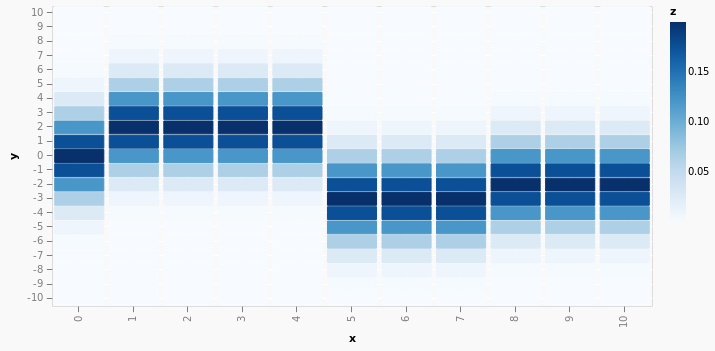

In [44]:
points1 = [(x, y, exp . ln $ likelihood nn (Data x y)) | x <- [0 .. 10], y <- [-10 .. 10]]

vlShow $
  plot
    (600, 300)
    (L [imagePlot "x" "y" "z"])
    ( Cols
        [ ("x", VL.Numbers ((\(x, _, _) -> x) <$> points1)),
          ("y", VL.Numbers ((\(_, x, _) -> x) <$> points1)),
          ("z", VL.Numbers ((\(_, _, x) -> x) <$> points1))
        ]
    )

Can you see the shifted and scaled step activation functions?
We are dealing with a three-node neural network here that has three steps:
Each element of the bias vector `[1, 5, 8]` corresponds to the x-value (right-shift) of the step function.
Each element of the weight vector `[2, -5, 1]` corresponds to its amplitude.
The neural network is thus simply a function with 3 steps at positions `biases` and with amplitudes `weights` - but neural network sounds fancier, doesn't it?

### Prior, Posterior and Predictive Distribution

Now let's try to "fit" something with this step-function network.
In our context, "fitting" means that we want to compare the data distributions that correspond to distribution of neural networks and assess which networks are more or less likely to generate the observed data.

How can we describe a distribution of neural networks?
Since these networks are defined through hmatrix `Vector` data types, we first need to find out how we can describe a distribution of those.
And here is everything that is needed to get a distribution of `Vector`s with uniformly distributed elements via `monad-bayes`:

In [45]:
sampleVec :: MonadSample m => (Double, Double) -> Int -> m (Vector Double)
sampleVec (wmin, wmax) nelements =
  vector <$> replicateM nelements (uniform wmin wmax)

From the distribution of vectors `MonadSample m => m (Vector Double)` that `sampleVec` generates, we can define a distribution of neural networks `MonadSample m => m NN`, the prior distribution, that we will assess in the inference process:

In [46]:
priorNN :: MonadSample m => Int -> m NN
priorNN nnodes = do
  bias <- sampleVec (0, 10) nnodes
  weight <- sampleVec (-10, 10) nnodes
  sigma <- uniform 0.5 1.5
  return $ NN bias weight sigma

Notice that the priors are chosen voluntarily to correspond to certain intervals.
Recall that our neural network is just a bunch of combined steps, where `biass` determines the step positions, and `weights` the step amplitudes.
The networks that we consider in our distribution are limited to steps between `0` and `10` on the x-axis, and to amplitudes between `-4` and `4`.
Inference is dead easy ...

In [47]:
postNN :: MonadInfer m => m NN -> [Data] ->  m NN
postNN pr obs = do
  nn <- pr
  forM_ obs (score . likelihood nn)
  return nn

... pull a neural network from the prior, compute how likely it is that it generates the observed data and update its prior by this value (score).
With the posterior distribution `postNN`, we can also predict new points:

In [48]:
predDist :: MonadInfer m => m NN -> m (NN, Data)
predDist pr = do
  nn <- pr
  x <- uniform 0 10
  y <- uniform (-5) 10
  score $ likelihood nn (Data x y)
  return (nn, Data x y)

Notice that we return the neural network parameters along with the actual data points for further examination here.

### Some Examples

We can now infer a predictive distribution from observations.
Let's see how our network deals with a line with slope `0.5` and intercept `-2`:

In [49]:
nsamples = 200
noise <- sampleIOfixed $ replicateM nsamples $ normal 0.0 0.5
observations = [Data x (0.5 * x - 2 + n) | (x,n) <- zip [0, (10 / nsamples) ..] noise]

We can sample from the posterior predictive distribution like this:

In [50]:
nnodes = 3
mkSampler = prior . mh 60000
predicted <- sampleIOfixed $ mkSampler $ predDist $ postNN (priorNN nnodes) observations

Which produces this distribution:

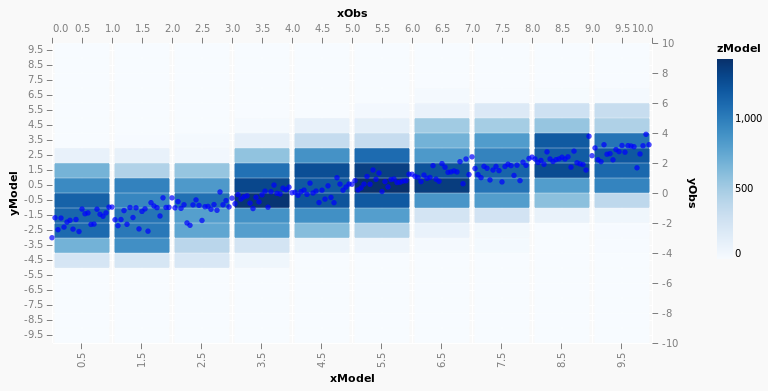

In [51]:
hist = histo2D (0, 10, 10) (-10, 20, 10) ((\(nn, d)-> (xValue d, yValue d)) <$> predicted)
cents = Vec.toList $ DH.binsCenters $ DH.bins hist
val = Vec.toList $ DH.histData hist
vlShow $
  plot
    (600, 300)
    (L [imagePlot "xModel" "yModel" "zModel",
        scatterBlue "xObs" "yObs" (0, 10) (-10, 10)])
    ( Cols
        [ ("xModel", VL.Numbers (fst <$> cents)),
          ("yModel", VL.Numbers (snd <$> cents)),
          ("zModel", VL.Numbers val),
          ("xObs", VL.Numbers (xValue <$> observations)),
          ("yObs", VL.Numbers (yValue <$> observations))
        ]
    )

The posterior predictive distribution, shown with a blue histogram, neatly follows the provided blue scatter points.
We have thus successfully fitted a line with a neural network using Bayesian inference!
But, where are the shifted and scaled steps that we saw so neatly before?
And why is the predictive distribution more widely spread than the data distribution?
Before we answer these questions, lets look at a more telling example, a sinus:

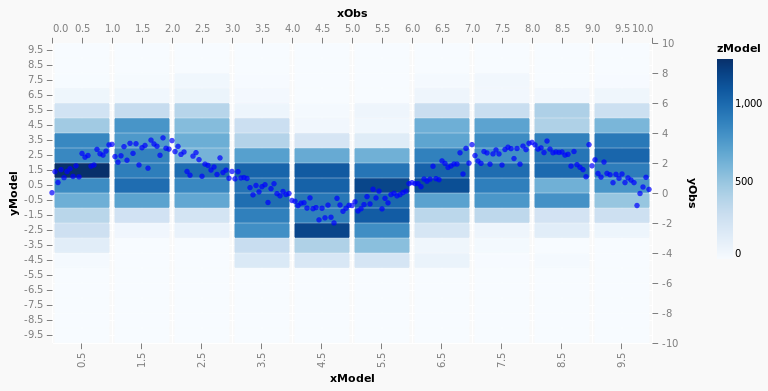

In [52]:
nsamples = 200
noise <- sampleIOfixed $ replicateM nsamples $ normal 0.0 0.5
observations = take nsamples [Data x (2 * sin x + 1 + n) | (x, n) <- zip [0, (10 / nsamples) ..] noise]

nnodes = 3
mkSampler = prior . mh 60000
predicted <- sampleIOfixed $ mkSampler $ predDist $ postNN (priorNN nnodes) observations

hist = histo2D (0, 10, 10) (-10, 20, 10) ((\(nn, d) -> (xValue d, yValue d)) <$> predicted)
cents = Vec.toList $ DH.binsCenters $ DH.bins hist
val = Vec.toList $ DH.histData hist
vlShow $
  plot
    (600, 300)
    (L [imagePlot "xModel" "yModel" "zModel", scatterBlue "xObs" "yObs" (0, 10) (-10, 10)])
    ( Cols
        [ ("xModel", VL.Numbers (fst <$> cents)),
          ("yModel", VL.Numbers (snd <$> cents)),
          ("zModel", VL.Numbers val),
          ("xObs", VL.Numbers (xValue <$> observations)),
          ("yObs", VL.Numbers (yValue <$> observations))
        ]
    )

This kind of works.
But again where are the steps? - we should have three of them since we used a 3 node network.
If you look cloesly, you can now actually see them:
the two peaks of the sinus correspond to two steps, and the trough to another.

But the model inferred quite a large standard deviation, certainly larger than the original `sigma = 0.5` that we used to generate the data.
We can check it out more closely in this histogram of the inferred sigma:

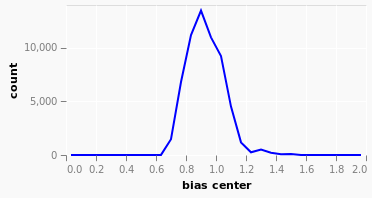

In [53]:
bs = sigma . fst <$> predicted

hist = histo (0.0, 30, 2.0) bs

cents = Vec.toList $ DH.binsCenters $ DH.bins hist
val = Vec.toList $ DH.histData hist
vlShow $ plot (300, 150)
              (L [linePlot "bias center" "count"])
              (Cols [("bias center", VL.Numbers cents),
                     ("count", VL.Numbers val)
                     ])

Why is the inferred sigma larger than the data sigma?
The reason is easy to understand and illuminates the meaning of the `errorModel`:
What have we done so far?
We have first generated data along a line (example 1) or a sinus (example 2) and added noise around.
We have then defined distributions that are _step functions_ with noise around and assessed those.
Step functions cannot naturally fit a line or a sinus, this _error_ of the forward model will necessarily be mapped into the `sigma` parameter that is larger than anticipated.
Note that this is fundamentally different to our previous blog post where we have generated data as line with noise and then inferred lines with noise around from it - there was no difference between the data generating model and our statistical model.
Yet, in real life we usually don't know the data generating processes and errors between our statistical model and reality are to always to be expected.
The error model is thus also different from some intrinsic stochasticity that the data generating process could have but that could be perfectly well described within our framework, for example with a specific _noise model_.

As a final step, let us actually look at the posterior distribution of weights and biases that we inferred.
In other words, what distribution of step positions and amplitudes do we expect after seeing the data?
Checkout this plot:

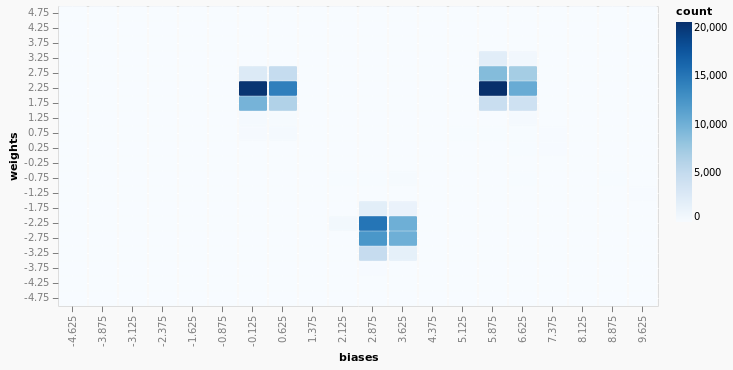

In [54]:
ws = mconcat $ toList . weights . fst <$> predicted
bs = mconcat $ toList . biass . fst <$> predicted

hist = histo2D (-5, 20, 10) (-5, 20, 5) (zip bs ws)
cents = Vec.toList $ DH.binsCenters $ DH.bins hist
val = Vec.toList $ DH.histData hist
vlShow $
  plot
    (600, 300)
    (L [imagePlot "biases" "weights" "count"])
    ( Cols
        [ ("biases", VL.Numbers (fst <$> cents)),
          ("weights", VL.Numbers (snd <$> cents)),
          ("count", VL.Numbers val)]
    )

It might look confusing but it is easy to understand:
the x-axis shows the step position (`biass`) and the y-axis shows the step amplitude (`weights`).
We have trained a three-node, that means three-step, neural network, and indeed we see three fixed positions and amplitudes in the histogram.
Around `(0, 2)`, around `(3, -3)` and around `(6, 2)` - yes, and indeed those are the steps that are fitting the sinus.
These values are quite approximate because we add a lot of deviation from those steps (standard deviation `1`) that we need because we are fitting a sinus with step functions.

### Conclusions

That's it.
In this blog post, we walked step-by-step through a very simple neural network model with the `monad-bayes` library.
It demonstrates how `monad-bayes` can be combined with other libraries such as `hmatrix` and illustrates the role of forward and error models in Bayesian analysis.

In future blog posts, we will explore more complex models, and also different sampling strategies.